## Exploring the structure ot triaxial halos using BFE

In [71]:
%pylab inline
from pygadgetreader import readsnap 
from scipy import special
from jellyfish import com
from jellyfish import profiles
from jellyfish import shapes
from gala.potential.scf import compute_coeffs, compute_coeffs_discrete
import bfe
from scipy.spatial.transform import Rotation as R

import sys
sys.path.append('../')
from mwlmc_bfe import coeff_energy


sys.path.append('../../../MWVPOS/code/')
import wake_mollweide_plots as moll_plots


Populating the interactive namespace from numpy and matplotlib


In [12]:
# Read data

In [3]:
path='../../../MW_anisotropy/code/test_snaps/'
snap='MW2_100M_beta1_vir_039'
MW_iso = bfe.ios.io_snaps.read_snap_coordinates(path, snap, 100000000-1, com_frame='MW', galaxy='MW')

Loading snapshot: ../../../MW_anisotropy/code/test_snaps/MW2_100M_beta1_vir_039
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Potential
Returning DM    Mass
Loading MW particles and LMC particles
Loading MW particles
Computing coordinates in the MW COM frame
Returning DISK  Positions
Returning DISK  Velocities
Returning DISK  Potential
[5.09300844 9.05520872 1.99982058] [2.58637234 7.97176483 1.95983295]


In [4]:
MW_iso_pos = MW_iso[0]

In [6]:
# free memory
del(MW_iso)

NameError: name 'MW_iso' is not defined

In [14]:
r = (MW_iso_pos[:,0]**2 + MW_iso_pos[:,1]**2 + MW_iso_pos[:,2]**2)**0.5
r_cut = np.where(r<350)[0]
xyz  = np.array([MW_iso_pos[r_cut][:,0], MW_iso_pos[r_cut][:,1], MW_iso_pos[r_cut][:,2]]).T

In [15]:
# Random sample:
rand = np.random.randint(0, len(r[r_cut]), 100000)
MW_iso_rand = MW_iso_pos[r_cut][rand]
xyz_rand = xyz[rand]

In [16]:
com.CM(MW_iso_rand, MW_iso_rand, np.ones(len(rand)))

(array([-0.48582317, -0.56981826, -0.84382518]),
 array([-0.33214274, -0.37271012, -0.45057198]))

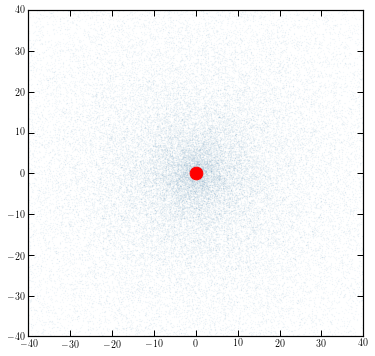

In [17]:
figure(figsize=(6,6))
scatter(MW_iso_rand[:,0], MW_iso_rand[:,1], s=0.01, alpha=0.2)
xlim(-40, 40)
ylim(-40, 40)
scatter(0,0, c='r', s=160)

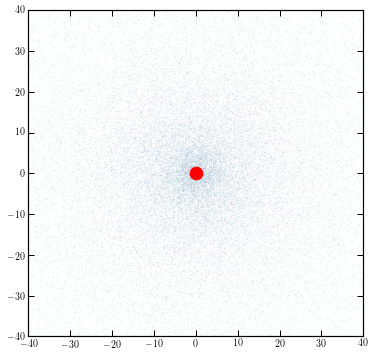

In [18]:
figure(figsize=(6,6))
scatter(MW_iso_rand[:,1], MW_iso_rand[:,2], s=0.01, alpha=0.2)
xlim(-40, 40)
ylim(-40, 40)
scatter(0,0, c='r', s=160)

In [19]:
N_part = len(rand)
mass = 1
mass_p = mass/N_part

In [20]:
def density_profile(pos, rmin, rmax, nbins):
    rho = np.zeros(nbins)
    r = np.linspace(rmin, rmax, nbins)
    dr = r[1]-r[0]
    r_pos = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    for i in range(len(r)-1):
        index = np.where((r_pos<r[i+1]) & (r_pos>r[i]))[0]
        V = 4/3. * np.pi * (r[i+1]**3 - r[i]**3)
        rho[i] = len(index)/V
    return rho, r+(dr/2)

In [21]:
rho_sph, r_sph = density_profile(MW_iso_rand, 2, 300, 100)

In [22]:
teo_halo = profiles.Hernquist(N_part, r_sph, 40.85)
#teo_NFW = profiles.NFW(len(pos[r_cut][rand]), r_sph, 40)

In [23]:
rho_teo = teo_halo.density()
#rho_NFW = teo_NFW.density()

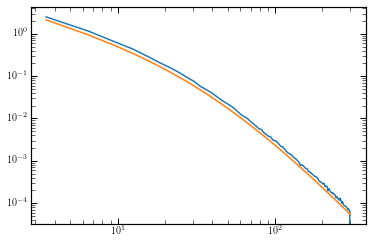

In [24]:
loglog(r_sph, rho_sph)
loglog(r_sph, rho_teo)
#loglog(r_sph, rho_NFW)
## Mismatch happens since I truncate the halo at 300 and thats not the total hernquist mass! 

# Coefficients analysis with gala:

In [27]:
mass_p

1e-05

In [28]:
N_part

100000

In [29]:
def write_halo(pos, halo_name):
    v = np.ones(len(pos[:,0]))
    array_pos = np.array([pos[:,0], pos[:,1], pos[:,2], v, v, v, v]).T
    np.savetxt(halo_name, array_pos)
    return 0

In [30]:
def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl

def Anl_array(nmax, lmax):
    A_nl_array = np.zeros((nmax, lmax))
    for j in range(nmax):
        for i in range(lmax):
            A_nl_array[j][i] = Anl(j, i)
    return A_nl_array

def coeff_energy(S, T, m, nmax, lmax):
    A_nl = Anl_array(nmax+1, lmax+1)
    A = (S[:,:,m]**2 + T[:,:,m]**2)**0.5/A_nl
    #im = ax.imshow(np.log10(np.abs(A/A_nl)).T, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    #fig.colorbar()
    return A

def asana_halo(xyz, s, q):
    """
    Make triaxial halos following the axis ratios definition:
    a>b>c
    s=c/a minor to mayor axis ratio
    q=b/a intermidate to mayor axis ratio
    oblate : T < 0.33
    prolate : T > 0.66
    triaxial : 0.33 < T < 0.66
    T = (1-q^2) / (1-s^2)
    
    """
    x = xyz[:,0]
    y = xyz[:,1]/q
    z = xyz[:,2]/s
    
    T = (1-q**2)/(1-s**2)
    if T < 0.33:
        print('Oblate', T)
    elif ((T>0.33) & (T<0.66)):
        print('Triaxial', T)
    elif (T>0.66):
        print('Prolate', T)
    return np.array([x, y, z]).T
    
def lotus_halo(xyz, mp, total_mass, rs_in, rs_out):
    """
    scale halos 
    """
    scale_f = rs_in/rs_out
    x = xyz[:,0]/scale_f
    y = xyz[:,1]/scale_f
    z = xyz[:,2]/scale_f
    n_particles = total_mass / mp
    rand_sample = np.random.randint(0, len(x), n_particles)
    print(n_particles)
    return np.array([x[rand_sample], y[rand_sample], z[rand_sample]].T)
    
    

## Halos 


Nathan Deg : 1, 2.15, 2.48
Law-Maweksi : 1, 2.2, 2.2,  with (c/a)ρ=0.44, (b/a)ρ=0.97

In [31]:
#contourf(S1, T1, np.log10(T), 30)
#colorbar()

In [32]:
(1-0.97**2)/(1-0.44**2)

0.07328869047619052

In [33]:
# Law-Majewsky halo:
xyz_LM10 = asana_halo(xyz_rand, 0.44, 0.97)


Oblate 0.07328869047619052


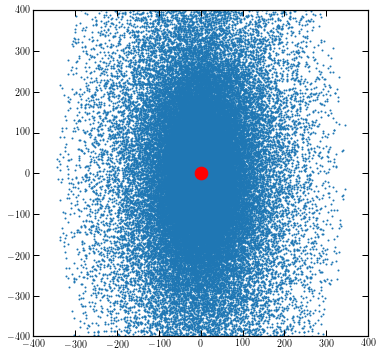

In [34]:
figure(figsize=(6,6))
scatter(xyz_LM10[:,0], xyz_LM10[:,2], s=1, alpha=1)
xlim(-400, 400)
ylim(-400, 400)
scatter(0,0, c='r', s=160)

In [60]:
xyz_chua = asana_halo(xyz_rand, 0.6, 0.3)


Prolate 1.421875


In [61]:
xyz_s1 = asana_halo(xyz, 0.2, 1)

xyz_s2 = asana_halo(xyz, 0.7, 1)

xyz_s3 = asana_halo(xyz, 0.9, 1)


Oblate 0.0
Oblate 0.0
Oblate 0.0


(-50, 50)

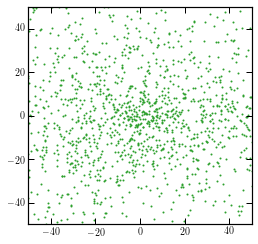

In [62]:
figsize(4,4)
scatter(xyz_chua[5000:10000,1], xyz_chua[5000:10000,2], s=1, c='C2')
xlim(-50, 50)
ylim(-50, 50)

In [53]:
vec, val, s, q = shapes.iterate_volume(xyz_s1, 30, 1E-3)
print(s, q, val)

0.62134737 0.70995975 [20.60982218+0.j 14.63214363+0.j 12.80585899+0.j]


In [56]:
vec, val, s, q = shapes.iterate_volume(xyz_s1, 20, 1E-3)


In [54]:
vec, val, s, q, pos_shell = shapes.iterate_shell(xyz_s1, 20, 3, 1E-3, return_pos=True)
print(s, q, val)

0.6093143 0.7112589 [5224021.5+0.j 2642776. +0.j 1939490.8+0.j]


In [55]:
vec, val, s, q, pos_shell = shapes.iterate_shell(xyz_s1, 16, 2, 1E-2, return_pos=True)
print(s, q, val)

0.58911294 0.7009492 [2838176.8+0.j 1394481. +0.j  985000.9+0.j]


In [12]:
vec, val, s, q, pos_shell = shapes.iterate_shell(xyz_s3, 19, 2, 1E-3, return_pos=True)
print(s, q, val)

0.94803894 0.96202135 [9017518.+0.j 8345577.+0.j 8104745.+0.j]


In [30]:
np.sqrt(3*val/len(pos_shell))

array([19.0633711 +0.j, 15.51045532+0.j, 13.57266569+0.j])

(-24, 24)

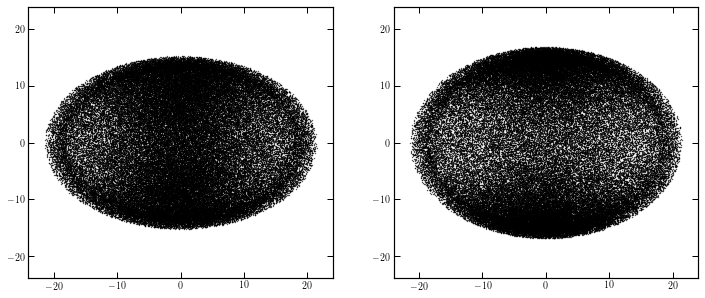

In [33]:
fig, ax = subplots(1, 2, figsize=(12, 5))
ax[0].scatter(pos_shell[:,0], pos_shell[:,2], c='k', s=0.1)
ax[0].set_xlim(-24, 24)
ax[0].set_ylim(-24, 24)

ax[1].scatter(pos_shell[:,0], pos_shell[:,1], c='k', s=0.1)
ax[1].set_xlim(-24, 24)
ax[1].set_ylim(-24, 24)


In [42]:
xyz_s1 = asana_halo(xyz, 0.5, 1)
xyz_s2 = asana_halo(xyz, 0.75, 1)
xyz_s3 = asana_halo(xyz, 0.9, 1)
xyz_q1 = asana_halo(xyz, 0.9, 0.5)
xyz_q2 = asana_halo(xyz, 0.9, 0.75)
xyz_q3 = asana_halo(xyz, 0.9, 0.9)

Oblate 0.0
Oblate 0.0
Oblate 0.0
Prolate 3.9473684210526327
Prolate 2.302631578947369
Prolate 1.0


In [45]:
xyz_t1 = asana_halo(xyz, 0.2, 0.8)
xyz_t2 = asana_halo(xyz, 0.4, 0.8)
xyz_t3 = asana_halo(xyz, 0.7, 0.9)
xyz_t4 = asana_halo(xyz, 0.8, 0.9)


Triaxial 0.3749999999999999
Triaxial 0.42857142857142844
Triaxial 0.37254901960784303
Triaxial 0.5277777777777778


In [66]:
rot = R.from_euler('zxy', [0, 45, 0], degrees=True)

In [67]:
xyz_chua_rot = rot.apply(xyz_chua)

(-200, 200)

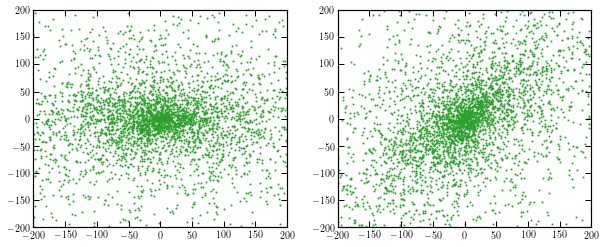

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(xyz_chua[5000:10000,1], xyz_chua[5000:10000,2], s=1, c='C2')
ax[0].set_xlim(-200, 200)
ax[0].set_ylim(-200, 200)


ax[1].scatter(xyz_chua_rot[5000:10000,1], xyz_chua_rot[5000:10000,2], s=1, c='C2')
ax[1].set_xlim(-200, 200)
ax[1].set_ylim(-200, 200)

In [80]:
asana_halo

<function __main__.asana_halo(xyz, s, q)>

In [81]:
def halo_rot(pos, angles, s, q):
    pos_shaped = asana_halo(xyz_rand, s, q)
    rot = R.from_euler('zxy', angles, degrees=True)
    pos_shaped_rotated = rot.apply(pos_shaped)
    return pos_shaped_rotated

In [88]:
prolate1 = halo_rot(xyz_rand, angles=[0, -30, 0], s=0.6, q=0.2)
prolate2 = halo_rot(xyz_rand, angles=[0, -30, 0], s=0.7, q=0.3)
prolate3 = halo_rot(xyz_rand, angles=[0, -30, 0], s=0.6, q=0.4)
prolate4 = halo_rot(xyz_rand, angles=[0, -30, 0], s=0.8, q=0.4)


Prolate 1.5
Prolate 1.7843137254901962
Prolate 1.3125
Prolate 2.333333333333334


In [89]:
def moll_plot(pos):
    l, b = moll_plots.pos_cartesian_to_galactic(pos)
    mwd_rot = moll_plots.mollweide_plot(l*180/np.pi, 90-b*180/np.pi)
    return mwd_rot

Sigma is 509.593080 arcmin (0.148235 rad) 
-> fwhm is 1200.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 509.593080 arcmin (0.148235 rad) 
-> fwhm is 1200.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 509.593080 arcmin (0.148235 rad) 
-> fwhm is 1200.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 509.593080 arcmin (0.148235 rad) 
-> fwhm is 1200.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


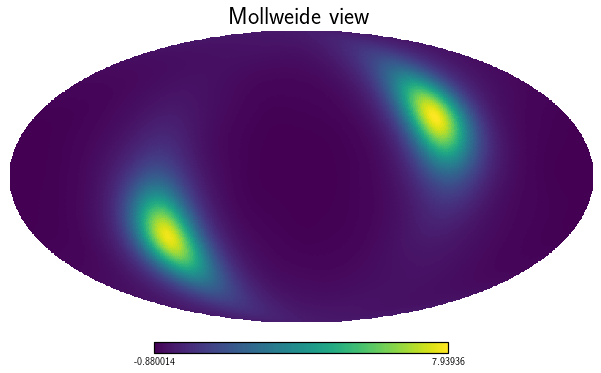

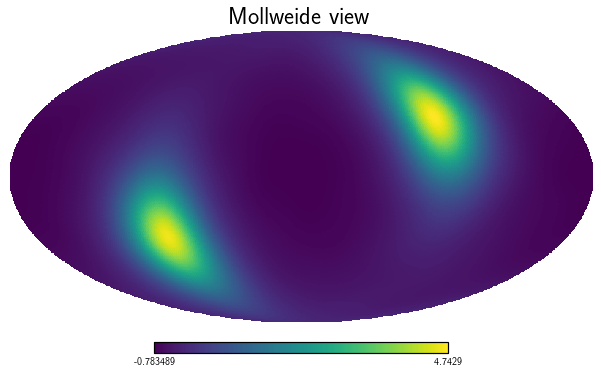

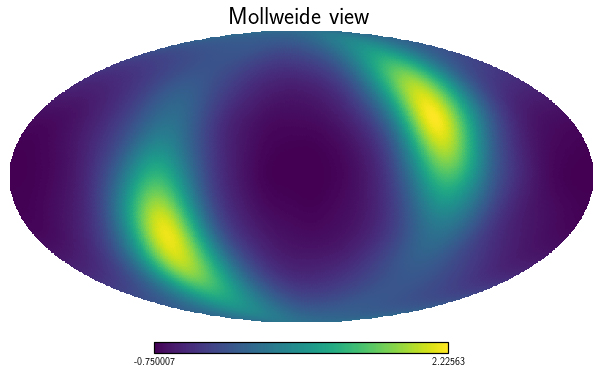

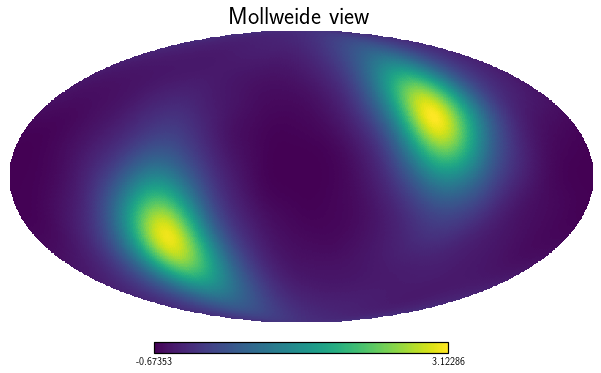

In [91]:
m1=moll_plot(prolate1)
m2=moll_plot(prolate2)
m3=moll_plot(prolate3)
m4=moll_plot(prolate4)

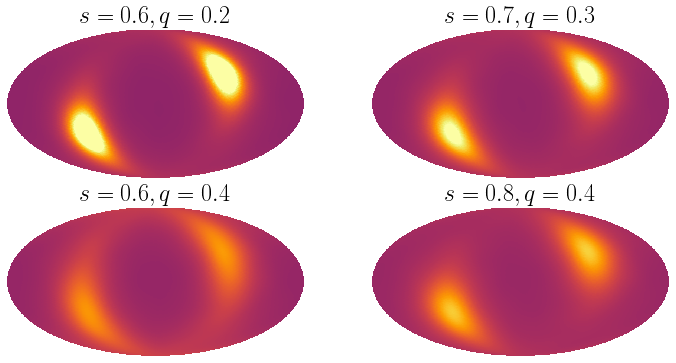

In [106]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
                       
ax[0][0].imshow(m1, origin='lower', extent=[-180, 180, -90, 90], cmap='inferno', vmin=-4, vmax=4)
ax[0][0].axis('off')

ax[0][1].imshow(m2, origin='lower', extent=[-180, 180, -90, 90], cmap='inferno', vmin=-4, vmax=4)
ax[0][1].axis('off')


ax[1][0].imshow(m3, origin='lower', extent=[-180, 180, -90, 90], cmap='inferno', vmin=-4, vmax=4)
ax[1][0].axis('off')


im1 = ax[1][1].imshow(m4, origin='lower', extent=[-180, 180, -90, 90], cmap='inferno', vmin=-4, vmax=4)
ax[1][1].axis('off')

ax[0][0].set_title(r'$s=0.6,q=0.2$')
ax[0][1].set_title(r'$s=0.7,q=0.3$')
ax[1][0].set_title(r'$s=0.6,q=0.4$')
ax[1][1].set_title(r'$s=0.8,q=0.4$')

savefig('prolate_halos_titled.png', bbox_inches='tight')


In [107]:
write_halo(prolate1, 'prolate1_s06_q02.txt')
write_halo(prolate2, 'prolate2_s07_q03.txt')
write_halo(prolate3, 'prolate3_s06_q04.txt')
write_halo(prolate4, 'prolate4_s08_q04.txt')


0

In [111]:
!head  -1 prolate1_s06_q02.txt

6.520163726806640625e+01 -1.294744934579935602e+02 6.275351725940156200e+01 1.000000000000000000e+00 1.000000000000000000e+00 1.000000000000000000e+00 1.000000000000000000e+00


(-300, 300)

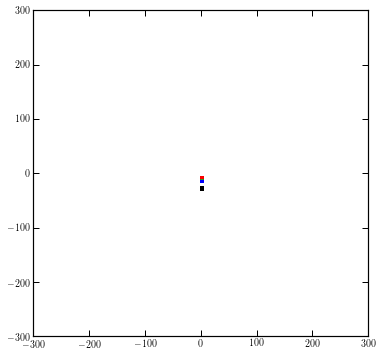

In [46]:
figure(figsize=(6,6))
scatter(xyz_t1[:1000,0], xyz_t1[:1000,2], s=1, c='k')
scatter(xyz_t2[:1000,0], xyz_t2[:1000,2], s=1, c='b')
scatter(xyz_t3[:1000,0], xyz_t3[:1000,2], s=1, c='C2')
scatter(xyz_t4[:1000,0], xyz_t4[:1000,2], s=1, c='r')

xlim(-300, 300)
ylim(-300, 300)

(-300, 300)

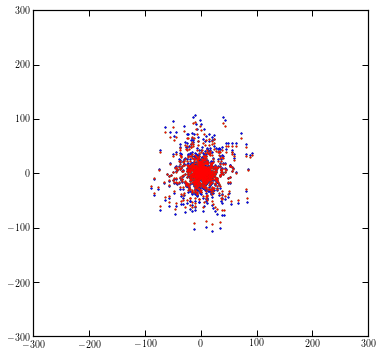

In [80]:
figure(figsize=(6,6))
scatter(xyz_t1[:1000,0], xyz_t1[:1000,1], s=1, c='k')
scatter(xyz_t2[:1000,0], xyz_t2[:1000,1], s=1, c='b')
scatter(xyz_t3[:1000,0], xyz_t3[:1000,1], s=1, c='C2')
scatter(xyz_t4[:1000,0], xyz_t4[:1000,1], s=1, c='r')

xlim(-300, 300)
ylim(-300, 300)

In [76]:
write_halo(xyz, 'spherical_halo.txt')

0

In [77]:
write_halo(xyz, 'spherical_halo.txt')
write_halo(xyz_s1, 's1_halo.txt')
write_halo(xyz_q1, 'q1_halo.txt')
write_halo(xyz_t1, 't1_halo.txt')

0

In [82]:
write_halo(xyz_t3, 't3_halo.txt')
write_halo(xyz_t4, 't4_halo.txt')

0

In [22]:
random2 = np.random.randint(0, len(xyz_2[:,0]), 10000)

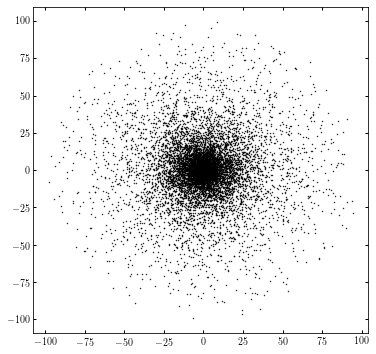

In [23]:
figure(figsize=(6,6))
scatter(xyz_2[random2,0], xyz_2[random2,1], c='k', s=0.2)

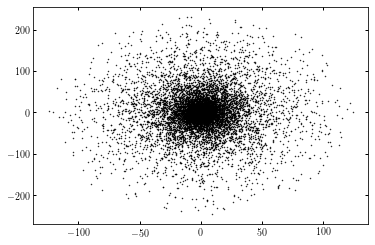

In [24]:
scatter(xyz_t2[random2,1], xyz_t2[random2,2], c='k', s=0.2)